In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"./Aleppo2017_processed.csv",encoding='utf-8')
print(df.head())

    id                 time     gl
0  183  2015-05-16 05:35:41  162.0
1  183  2015-05-16 05:30:41  164.0
2  183  2015-05-16 05:25:41  168.0
3  183  2015-05-16 05:20:41  169.0
4  183  2015-05-16 05:15:41  170.0


In [2]:
ID = df['id'].value_counts().index
pd.set_option('display.max_rows',100)
print(ID)

Index([263,  77, 193, 277, 229, 245, 155, 251, 111, 164,
       ...
       128, 264, 186, 162, 249,  39,  52, 266, 223, 289],
      dtype='int64', name='id', length=226)


In [3]:
all_data = []
for i in ID[:10]:
    #获取数据
    print("开始获取id为{}的被试的数据：---------------------------------".format(i))
    data = df[df['id']== i].copy()

    #将time列设成date数据类型
    data['time'] = pd.to_datetime(data['time'])
    
    #按照时间排序
    data = data.sort_values(by='time') 
    
    #提取月为单独的一列
    data['month'] = data['time'].dt.month
    
    #提取日为单独的一列
    data['day'] = data['time'].dt.day
    
    #提取小时为单独的一列
    data['hour'] = data['time'].dt.hour
    
    #提取分钟为单独的一列
    data['minute'] = data['time'].dt.minute
    
    # 提取周几（0表示星期一，1表示星期二，依此类推）
    data['weekday'] = data['time'].dt.dayofweek
    
    data = data.set_index('time')
    
    data['target'] = data['gl'].shift(-1)
    
    # 使用了shift函数，在最后必然是有缺失值的，这里去掉缺失值所在行
    data.dropna()                     
    data = data[['month','day','hour','minute','weekday','gl','target']][:1000].astype(np.float32).values  # 修改数据类型
    all_data.append(data)

开始获取id为263的被试的数据：---------------------------------
开始获取id为77的被试的数据：---------------------------------
开始获取id为193的被试的数据：---------------------------------
开始获取id为277的被试的数据：---------------------------------
开始获取id为229的被试的数据：---------------------------------
开始获取id为245的被试的数据：---------------------------------
开始获取id为155的被试的数据：---------------------------------
开始获取id为251的被试的数据：---------------------------------
开始获取id为111的被试的数据：---------------------------------
开始获取id为164的被试的数据：---------------------------------


In [4]:
all_data = np.array(all_data)
print(all_data.shape)

test_data_size = 100
train_data = all_data[:,:-test_data_size,:]
test_data = all_data[:,-test_data_size:,:]

(10, 1000, 7)


In [5]:
print(train_data.shape)
print(test_data.shape)

(10, 900, 7)
(10, 100, 7)


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_data = scaler.fit_transform(train_data.reshape(-1, 7)).reshape(10, -1, 7)
normalized_data.shape

(10, 900, 7)

In [8]:
import torch
import torch.nn as nn
normalized_data = torch.FloatTensor(normalized_data)
print(normalized_data[0,:5,:])

tensor([[-1.0000, -1.0000, -0.7391, -0.6271,  1.0000, -0.7278, -0.7389],
        [-1.0000, -1.0000, -0.7391, -0.4576,  1.0000, -0.7389, -0.7556],
        [-1.0000, -1.0000, -0.7391, -0.2881,  1.0000, -0.7556, -0.7611],
        [-1.0000, -1.0000, -0.7391, -0.1186,  1.0000, -0.7611, -0.7667],
        [-1.0000, -1.0000, -0.7391,  0.0508,  1.0000, -0.7667, -0.7722]])


In [9]:
def create_inout_sequences(input_data, tw):
    train_x = []
    train_y = []
    L = input_data.shape[1]
    for j in range(input_data.shape[0]):
        for i in range(L-tw):
            train_seq = input_data[j,i:i+tw,:-1]
            
            train_label = input_data[j,i+tw:i+tw+1,-1]
            
            train_x.append(train_seq)
            
            train_y.append(train_label)
            
    train_x_tensor = torch.stack(train_x, dim=0)
    train_y_tensor = torch.stack(train_y, dim=0)
    return train_x_tensor, train_y_tensor

In [11]:
from torch.utils.data import TensorDataset,DataLoader
train_window = 24
train_x, train_y = create_inout_sequences(normalized_data, train_window)
print(train_x.shape)
print(train_y.shape)
train = TensorDataset(train_x,train_y)
batch_size = 256
train_loader = DataLoader(dataset=train,batch_size=batch_size, shuffle=False)

torch.Size([8760, 24, 6])
torch.Size([8760, 1])


In [12]:
device = torch.device("cuda:0")
class myLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(myLSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer 在LSTM后再加一个全连接层，因为是回归问题，所以不能在线性层后加激活函数
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 这里x.size(0)就是batch_size

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])

        return out

In [13]:
input_dim = 6  # 数据的特征数
hidden_dim = 64  # 隐藏层的神经元个数
num_layers = 2  # LSTM的层数
output_dim = 1  # 预测值的特征数

In [14]:
model = myLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
if torch.cuda.is_available():
    allen = model.cuda()

In [15]:
# 定义优化器和损失函数
loss_fn = torch.nn.MSELoss(reduction='mean')  # 使用均方误差作为损失函数
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)  # 使用Adam优化算法
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

In [18]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter("E:\pythonProject\RNN_study\logs")

# 设定数据遍历次数
num_epochs = 50
# 记录训练次数
total_train_step = 0
# 记录测试次数
total_test_step = 0

for t in range(num_epochs):
    print("----------第 {} 轮训练开始----------".format(t + 1))
    model.train()
    for data in train_loader:
        trains, targets = data

        if torch.cuda.is_available():
            trains = trains.cuda()
            targets = targets.cuda()
            
        y_train_pred = model(trains)
#         print("targets.shape:", targets.shape)
#         print("y_train_pred.shape",y_train_pred.shape)
        loss = loss_fn(y_train_pred, targets)
#         print("MSE: ",loss)
        optimiser.zero_grad()  # 梯度清零

        # Backward pass
        loss.backward()  # 反向传播

        # Update parameters
        optimiser.step()  # 参数优化
        
        total_train_step += 1
        
        if total_train_step % 50 == 0 :  # 每训练100次，打印一次均方差
            print("训练次数： ", total_train_step, "MSE: ", loss.item())
        # 逢100记录一次Loss
        
#         writer.add_scalar("train_loss", loss.item(), total_train_step)
        
    torch.save(model, r"E:\pythonProject\RNN_study\CGM\pre_trained_model\allen_{}.pth".format(t))
    
    print("allen_{}.pth 模型已保存".format(t))
    
# writer.close()

----------第 1 轮训练开始----------
allen_0.pth 模型已保存
----------第 2 轮训练开始----------
训练次数：  50 MSE:  0.00386304734274745
allen_1.pth 模型已保存
----------第 3 轮训练开始----------
训练次数：  100 MSE:  0.014306716620922089
allen_2.pth 模型已保存
----------第 4 轮训练开始----------
allen_3.pth 模型已保存
----------第 5 轮训练开始----------
训练次数：  150 MSE:  0.010989725589752197
allen_4.pth 模型已保存
----------第 6 轮训练开始----------
训练次数：  200 MSE:  0.003543516155332327
allen_5.pth 模型已保存
----------第 7 轮训练开始----------
allen_6.pth 模型已保存
----------第 8 轮训练开始----------
训练次数：  250 MSE:  0.005935885012149811
allen_7.pth 模型已保存
----------第 9 轮训练开始----------
训练次数：  300 MSE:  0.014758158475160599
allen_8.pth 模型已保存
----------第 10 轮训练开始----------
训练次数：  350 MSE:  0.004744661971926689
allen_9.pth 模型已保存
----------第 11 轮训练开始----------
allen_10.pth 模型已保存
----------第 12 轮训练开始----------
训练次数：  400 MSE:  0.0019580204971134663
allen_11.pth 模型已保存
----------第 13 轮训练开始----------
训练次数：  450 MSE:  0.008847546763718128
allen_12.pth 模型已保存
----------第 14 轮训练开始--------

In [24]:
test_inputs = normalized_data[:,-train_window:,:-1]
print(test_inputs.shape)

torch.Size([10, 24, 6])


In [25]:
model = torch.load(r"E:\pythonProject\RNN_study\CGM\pre_trained_model\allen_49.pth")
print(model)
fut_pred = 1
model.eval()
test_inputs = torch.FloatTensor(test_inputs).cuda()

myLSTM(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [26]:
for i in range(fut_pred):    
    with torch.no_grad():
        output = model(test_inputs[:,-train_window:,:])
#         print(output.shape)
#         test_inputs = torch.cat((test_inputs,output.unsqueeze(1)), dim=1)
print(output)
print(test_inputs.shape)

tensor([[ 0.1024],
        [ 0.1376],
        [-0.3159],
        [-0.8473],
        [-0.5585],
        [-0.3041],
        [-0.8880],
        [-0.7875],
        [-0.7458],
        [-0.0441]], device='cuda:0')
torch.Size([10, 24, 6])


In [207]:
test_inputs = test_inputs.cpu()
test_inputs_targets = scaler.inverse_transform(np.array(test_inputs.view(-1,6)))
test_inputs_targets = test_inputs_targets.reshape(100,-1,6)
print(test_inputs_targets)

[[[  4.         10.          0.         48.          4.
   122.999985 ]
  [  4.         10.          0.         53.          4.
   127.       ]
  [  4.         10.          0.         58.          4.
   131.       ]
  ...
  [  5.7886004  15.964431   13.652189   31.976622    3.5035152
   263.64523  ]
  [  5.7566752  16.536491   13.356014   32.221878    3.8886912
   261.8403   ]
  [  6.047967   20.115759   13.271953   31.217724    3.147628
   257.05115  ]]

 [[  3.         25.          0.         35.          2.
   224.       ]
  [  3.         25.          0.         40.          2.
   228.       ]
  [  3.         25.          0.         45.          2.
   232.       ]
  ...
  [  5.7561674  22.130924   12.588385   30.987165    3.4109502
   253.4126   ]
  [  6.002771   14.092164   13.16369    32.632942    3.7349918
   282.3797   ]
  [  5.798568   19.812193   12.686945   30.404707    3.189527
   251.26282  ]]

 [[  4.          3.9999995  12.         18.          5.
   118.       ]
  [  4. 

In [208]:
predict = test_inputs_targets[:,24:,-1]
print(predict.shape)

(100, 24)


In [209]:
predict

array([[218.19771, 234.47444, 253.93045, ..., 263.64523, 261.8403 ,
        257.05115],
       [229.1257 , 229.89891, 207.19931, ..., 253.4126 , 282.3797 ,
        251.26282],
       [226.17451, 249.52155, 232.66759, ..., 214.77956, 220.02814,
        217.16798],
       ...,
       [273.6846 , 233.81212, 261.80203, ..., 259.52466, 259.40955,
        235.74132],
       [243.52847, 265.4722 , 263.29922, ..., 255.72047, 259.0189 ,
        247.49132],
       [234.84009, 278.40457, 231.4926 , ..., 237.14198, 228.32663,
        224.14311]], dtype=float32)

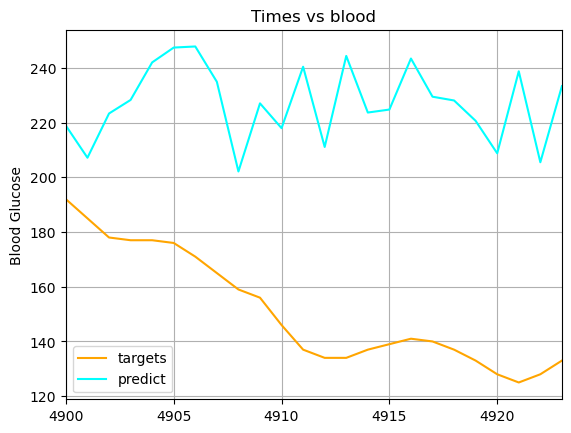

In [224]:
x = np.arange(4900,4924,1)
# print(x)
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,8),dpi=80)

plt.title('Times vs blood')
plt.ylabel('Blood Glucose')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(x,test_data[20,:24,-1], label='targets',color='orange')
plt.plot(x,predict[20], label='predict',color='cyan')
plt.legend()
plt.show()

In [213]:
test_data.shape

(100, 50, 6)